In [ ]:
!pip install pyspark

In [ ]:
import pyspark
print(pyspark.__version__)

3.5.4


In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Verify that the drive is mounted
!ls /content/drive/MyDrive/spark

HPI_AT_BDL_ZIP3.csv  HPI_AT_BDL_ZIP5.csv  Zip_Zhvi_Summary_AllHomes.csv


In [ ]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("ColabPySpark").getOrCreate()

# Verify Spark session
print(spark)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, desc, expr
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName("ColabPySpark").getOrCreate()

In [ ]:
zip3 = spark.read.csv("/content/drive/MyDrive/spark/HPI_AT_BDL_ZIP3.csv", header=True, inferSchema=True)
zip5 = spark.read.csv("/content/drive/MyDrive/spark/HPI_AT_BDL_ZIP5.csv", header=True, inferSchema=True)
zhvi = spark.read.csv("/content/drive/MyDrive/spark/Zip_Zhvi_Summary_AllHomes.csv", header=True, inferSchema=True)


In [ ]:
# Convert relevant columns to numeric
zip3 = zip3.withColumn("HPI", col("HPI").cast("double"))
zip3 = zip3.withColumn("Annual Change (%)", col("Annual Change (%)").cast("double"))

zip5 = zip5.withColumn("HPI", col("HPI").cast("double"))
zip5 = zip5.withColumn("Annual Change (%)", col("Annual Change (%)").cast("double"))

zhvi = zhvi.withColumn("Zhvi", col("Zhvi").cast("double"))

In [ ]:
# ---- Step 1: Compare Trends Between ZIP3 and ZIP5 ----
# Aggregate HPI by Year
zip3_trends = zip3.groupBy("Year").agg(mean("HPI").alias("Avg_HPI")).orderBy("Year").toPandas()
zip5_trends = zip5.groupBy("Year").agg(mean("HPI").alias("Avg_HPI")).orderBy("Year").toPandas()


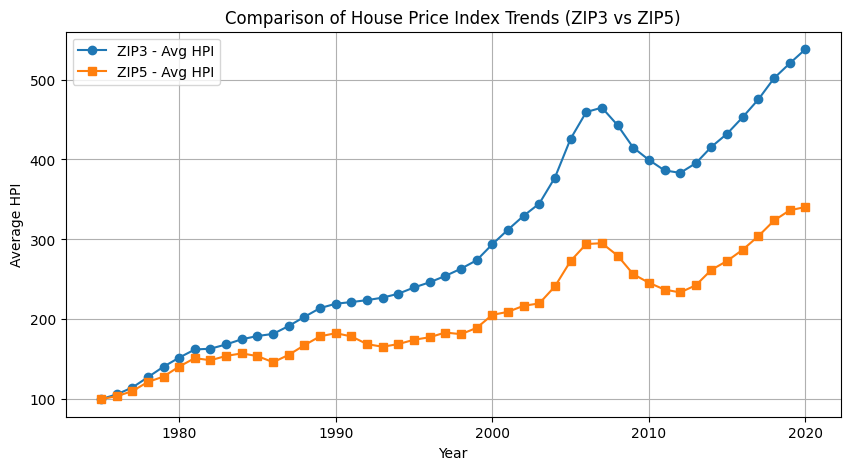

In [ ]:
# Plot trends
plt.figure(figsize=(10, 5))
plt.plot(zip3_trends["Year"], zip3_trends["Avg_HPI"], label="ZIP3 - Avg HPI", marker="o")
plt.plot(zip5_trends["Year"], zip5_trends["Avg_HPI"], label="ZIP5 - Avg HPI", marker="s")
plt.xlabel("Year")
plt.ylabel("Average HPI")
plt.title("Comparison of House Price Index Trends (ZIP3 vs ZIP5)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ---- Step 2: Identify ZIP Regions with Highest and Lowest Price Changes ----
top_zip3_changes = zip3.orderBy(desc("Annual Change (%)")).limit(5).toPandas()
bottom_zip3_changes = zip3.orderBy("Annual Change (%)").limit(5).toPandas()

top_zip5_changes = zip5.orderBy(desc("Annual Change (%)")).limit(5).toPandas()
bottom_zip5_changes = zip5.orderBy("Annual Change (%)").limit(5).toPandas()

# Display top & bottom price changes
print("Top 5 ZIP3 Price Increases")
display(pd.DataFrame(top_zip3_changes))

print("Bottom 5 ZIP3 Price Decreases")
display(pd.DataFrame(bottom_zip3_changes))

print("Top 5 ZIP5 Price Increases")
display(pd.DataFrame(top_zip5_changes))

print("Bottom 5 ZIP5 Price Decreases")
display(pd.DataFrame(bottom_zip5_changes))

Top 5 ZIP3 Price Increases


,Three-Digit ZIP Code,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base,_c6
0,743,1983,86.01,225.01,177.41,102.60,None
1,316,1984,71.35,171.35,92.60,71.15,None
2,143,1979,60.14,167.05,74.98,66.81,None
3,619,1985,58.87,103.86,83.77,58.24,None
4,988,1983,53.79,185.91,75.99,45.88,None


Bottom 5 ZIP3 Price Decreases


,Three-Digit ZIP Code,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base,_c6
0,12,1980,NaN,100.0,39.33,38.12,None
1,10,1975,NaN,100.0,23.16,21.64,None
2,11,1975,NaN,100.0,19.46,20.73,None
3,13,1985,NaN,100.0,60.43,55.09,None
4,14,1976,NaN,100.0,25.76,20.13,None


Top 5 ZIP5 Price Increases


,Five-Digit ZIP Code,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base,_c6,_c7
0,33062,1983,94.74,177.88,77.64,53.59,None,None
1,80219,1979,91.09,223.51,116.82,50.59,None,None
2,94608,1981,81.98,278.82,108.34,61.00,None,None
3,78231,1982,81.44,135.93,111.31,89.58,None,None
4,32117,1982,80.44,193.03,101.42,75.71,None,None


Bottom 5 ZIP5 Price Decreases


,Five-Digit ZIP Code,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base,_c6,_c7
0,55055,1991,NaN,100.0,.,59.90,None,None
1,1008,2002,NaN,100.0,.,.,None,None
2,55063,1998,NaN,100.0,.,89.43,None,None
3,1005,1992,NaN,100.0,.,81.01,None,None
4,55056,1991,NaN,100.0,.,59.13,None,None


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# ---- Step 3: Merge ZIP5 HPI with Zillow ZHVI Data ----
# Convert ZIP code columns to string for merging
zhvi = zhvi.withColumn("RegionName", col("RegionName").cast("string"))
zip5 = zip5.withColumn("Five-Digit ZIP Code", col("Five-Digit ZIP Code").cast("string"))

In [ ]:
# Perform inner join on ZIP code
df_combined = zip5.join(zhvi, zip5["Five-Digit ZIP Code"] == zhvi["RegionName"], "inner")\
    .select("HPI", "Zhvi").toPandas()


In [ ]:
# ---- Step 4: Compute Correlation ----
correlation = df_combined.corr().loc["HPI", "Zhvi"]

NameError: name 'df_combined' is not defined

In [ ]:
# Print correlation result
print(f"Correlation between Zillow ZHVI and ZIP5 HPI: {correlation:.4f}")

Correlation between Zillow ZHVI and ZIP5 HPI: 0.4457


In [ ]:
# Convert necessary columns to numeric
zip5 = zip5.withColumn("HPI", col("HPI").cast("double"))

zhvi = zhvi.withColumn("Zhvi", col("Zhvi").cast("double"))
zhvi = zhvi.withColumn("State", col("State").cast("string"))

In [ ]:
from pyspark.sql.functions import stddev, mean, col


In [ ]:
zip5 = zip5.withColumn("HPI", col("HPI").cast("double"))


In [ ]:
 # Identify ZIP Codes with Highest HPI Volatility (Standard Deviation)
zip5_volatility = zip5.groupBy("Five-Digit ZIP Code") \
    .agg(stddev("HPI").alias("HPI_Volatility")) \
    .orderBy(col("HPI_Volatility").desc()) \
    .limit(10) \
    .toPandas()

# Display the Most Volatile ZIP Codes
print("Top 10 Most Volatile ZIP Codes (Based on HPI Standard Deviation)")
display(zip5_volatility)


Top 10 Most Volatile ZIP Codes (Based on HPI Standard Deviation)


,Five-Digit ZIP Code,HPI_Volatility
0,98105,759.812557
1,95124,730.282926
2,94025,714.472364
3,95129,710.477562
4,94131,698.301593
5,94086,694.672676
6,94539,671.938802
7,94110,671.687851
8,90066,669.032329
9,94112,643.681039


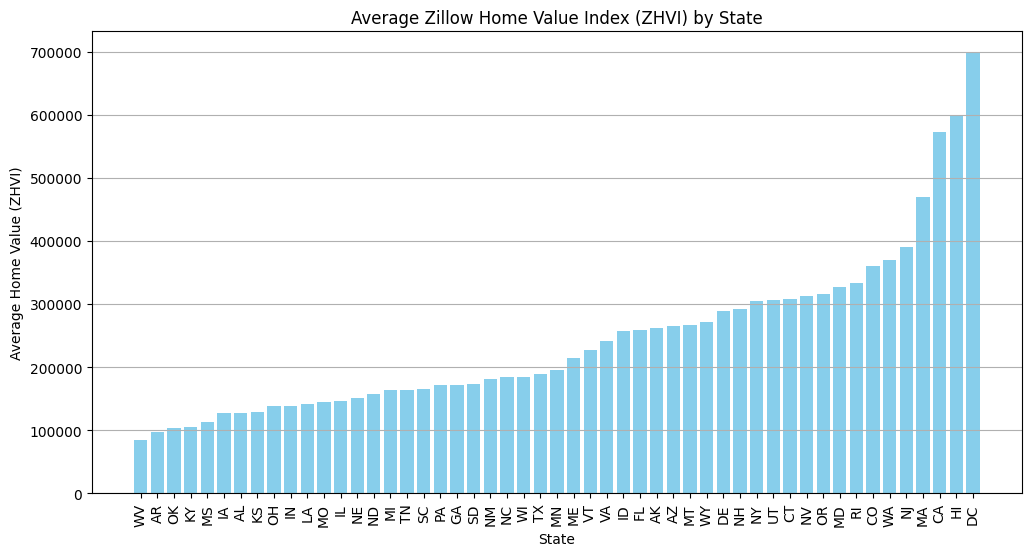

In [ ]:
#  Average Home Value (ZHVI) by State ----
state_zhvi = zhvi.groupBy("State") \
    .agg(mean("Zhvi").alias("Avg_Zhvi")) \
    .orderBy(col("Avg_Zhvi").asc()) \
    .toPandas()

# Plot average home values by state
plt.figure(figsize=(12, 6))
plt.bar(state_zhvi["State"], state_zhvi["Avg_Zhvi"], color="skyblue")
plt.xlabel("State")
plt.ylabel("Average Home Value (ZHVI)")
plt.title("Average Zillow Home Value Index (ZHVI) by State")
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.show()

In [ ]:
spark.stop()